# General moment calculation for a two- and three-state promoter.

(c) 2018 Manuel Razo. This work is licensed under a [Creative Commons Attribution License CC-BY 4.0](https://creativecommons.org/licenses/by/4.0/). All code contained herein is licensed under an [MIT license](https://opensource.org/licenses/MIT). 

---

In [1]:
# Library that we will use to export lambdify functions
import cloudpickle
import dill 

import itertools # Library we'll use to generate possible pairs of numbers

# Numerical workhorse
import numpy as np

# To compute symbolic expressions
import sympy
sympy.init_printing(use_unicode=True, use_latex=True) # print outputs in LaTeX

# Import matplotlib stuff for plotting
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib as mpl

# Seaborn, useful for graphics
import seaborn as sns

# Import the utils for this project
import chann_cap_utils as chann_cap

# Set PBoC plotting style
chann_cap.set_plotting_style()

# Magic function to make matplotlib inline
%matplotlib inline

# This enables SVG graphics inline. 
%config InlineBackend.figure_formats = {'png', 'retina'}

tmpdir = '../../tmp/'

# $\LaTeX$ macros
$\newcommand{kpon}{k^p_{\text{on}}}$
$\newcommand{kpoff}{k^p_{\text{off}}}$
$\newcommand{kron}{k^r_{\text{on}}}$
$\newcommand{kroff}{k^r_{\text{off}}}$
$\newcommand{rm}{r _m}$
$\newcommand{gm}{\gamma _m}$
$\newcommand{ee}[1]{\left\langle #1 \right\rangle}$
$\newcommand{bb}[1]{\mathbf{#1}}$
$\newcommand{th}[1]{{#1}^{\text{th}}}$
$\newcommand{dt}[1]{{\partial{#1} \over \partial t}}$
$\newcommand{Km}{\bb{K}}$
$\newcommand{Rm}{\bb{R}_m}$
$\newcommand{Gm}{\bb{\Gamma}_m}$
$\newcommand{Rp}{\bb{R}_p}$
$\newcommand{Gp}{\bb{\Gamma}_p}$

## General calculation of the moments of the distribution.

In order to approximate the entire mRNA and protein distribution $P(m, p)$ we use the maximum entropy approach in which moments $\ee{m^x p^y}$ with $x, y \in \mathbb{Z}$ are used to approximate the distribution as
$$
\hat{P}(m, p) = {e^{\sum_{j} \beta_j m^{x_j} p^{y_j}} \over \mathcal{Z}},
$$
where $\beta_j$ is the Lagrange multiplier associated with the $\th{j}$ constraint of the form $\ee{m^{x_j} p^{y_j}}$, and $\mathcal{Z}$ is the partition funciton defined as
$$
\mathcal{Z} = \sum_m \sum_p e^{\sum_{j} \beta_j m^{x_j} p^{y_j}}.
$$

In particular for our system the master equation that describes the time evolution of the distribution is defined by either two or three differential equations, one for each state of the promoter such that
$$
P(m, p) = \sum_{s\in \text{states}} P_s(m, p),
$$
where $s \in \{E, P, R\}$ defines the state $E =$ empty state, $P =$ RNAP bound, and $R =$ repressor bound. The third state is only include in the case where there is transcription factor present. Without loss of generality let's focus here on the three-state promoter. Let $\bb{P}(m, p) = (P_E(m, p), P_P(m, p), P_R(m, p))$ be the vector containing all distributions. Using this notation the system of PDEs that define the distribution is given by
$$
\dt{\bb{P}(m, p)} = \overbrace{
\left(\Km - \Rm - m\Gm - m\Rp -p\Gp \right) \bb{P}(m, p)
}^{\text{exit state }m,p}\\
\overbrace{
+ \Rm \bb{P}(m-1, p) + \Gm (m + 1) \bb{P}(m+1, p)\\
+ \Rp (m) \bb{P}(m, p-1) + \Gm (p + 1) \bb{P}(m, p+1)
}^{\text{enter state }m,p},
\label{master_matrix}
$$
where $\Km$ is the matrix defining transition rates between states, $\Rm$ and $\Gm$ are the matrices defining the production and degradation rates of mRNA respectively, and $\Rp$ and $\Gp$ are the equivalent matrices for the production and degradation of protein.

Given this birth-death process with three different states of the promoter if we want to compute a moment $\ee{m^x p^y}$ we would actually compute
$$
\ee{m^x p^y} = \ee{m^x p^y}_E + \ee{m^x p^y}_P + \ee{m^x p^y}_R,
$$
i.e. the moment at each of the states of the promoter. Let 
$\bb{\ee{m^x p^y}} = \left(\ee{m^x p^y}_E, \ee{m^x p^y}_P, \ee{m^x p^y}_R\right)$ be a vector containing all three moments. The moment PDE is then given by
$$
\dt{\bb{\ee{m^x p^y}}} = \sum_m \sum_p \dt{\bb{P}(m,p)}.
$$

This is computed using Eq. \ref{master_matrix} obtaining
$$
\dt{\bb{\ee{m^x p^y}}} = 
\sum_m \sum_p \left(\Km - \Rm - m\Gm - m\Rp -p\Gp \right)m^x p^y \bb{P}(m, p)\\
\overbrace{
+ \Rm \sum_m \sum_p m^x p^y \bb{P}(m-1, p) 
}^{1}
\overbrace{
+ \Gm \sum_m \sum_p (m + 1) m^x p^y \bb{P}(m+1, p)
}^{2}\\
\overbrace{
+ \Rp \sum_m \sum_p (m) m^x p^y \bb{P}(m, p-1) 
}^{3}
\overbrace{
+ \Gm \sum_m \sum_p (p + 1) m^x p^y \bb{P}(m, p+1)
}^{4}.
\label{master_moment_sum}
$$
Each of the numbered terms have stereotypical "tricks" to simplify them. Let's list them (derivation left elsewhere):
$$
1: m' \equiv m - 1\\
\Rightarrow
\sum_m \sum_p m^x p^y \bb{P}(m-1, p) = 
\sum_{m'} \sum_p (m' + 1)^x p^y \bb{P}(m', p) = \\
\bb{\ee{(m+1)^x p^y}},
$$
$$
2: m' \equiv m + 1\\
\Rightarrow
\sum_m \sum_p (m + 1) m^x p^y \bb{P}(m + 1, p) = 
\sum_{m'} \sum_p m' (m' - 1)^x p^y \bb{P}(m', p) = \\
\bb{\ee{m (m - 1)^x p^y}},
$$
$$
3: p' \equiv p - 1\\
\Rightarrow
\sum_m \sum_p (m) m^x p^y \bb{P}(m, p-1) =
\sum_m \sum_{p'} m^{x + 1} (p' + 1)^y \bb{P}(m, p') = \\
\bb{\ee{m^{x + 1} (p +  1)^{y}}},
$$
$$
4: p' \equiv p + 1\\
\Rightarrow
\sum_m \sum_p (p + 1) m^x p^y \bb{P}(m, p+1) =
\sum_m \sum_{p'} p' m^x (p' - 1)^y \bb{P}(m, p') = \\
\bb{\ee{m^x p (p - 1)^y}}.
$$

Given these tricks and Eq. \ref{master_moment_sum} we can write a **general** form for the moment PDE given by
$$
\dt{\bb{\ee{m^x p^y}}} =
\Km \bb{\ee{m^x p^y}} +\\
\Rm \left[ \bb{\ee{(m+1)^x p^y}} - \bb{\ee{m^x p^y}} \right] +\\
\Gm \left[ \bb{\ee{m (m - 1)^x p^y}} - \bb{\ee{m^{x + 1} p^y}} \right] +\\
\Rp \left[ \bb{\ee{m^{x + 1} (p +  1)^{y}}} - \bb{\ee{m^{x+1} p^y}} \right] +\\
\Gp \left[ \bb{\ee{m^x p (p - 1)^y}} - \bb{\ee{m^x p^{y+1}}} \right]
\label{master_moment}
$$

## Using `sympy` to compute moments

The objective of this notebook is to use `sympy` in order to set \ref{master_moment} to steady state and solve the equation for the desired moment $\bb{\ee{m^x p^y}}$. This is going to be a function of all moments $\bb{\ee{m^{x'} p^{y'}}}$ with $x' + y' \leq x + y$. For example for the protein second moment $\bb{\ee{p^2}}$ we would need to know
$$
\bb{\ee{p^2}} = f\left(\bb{\ee{m^0 p^0}}, \bb{\ee{m^1 p^0}}, \bb{\ee{m^2 p^0}},
\bb{\ee{m^0 p^1}}, \bb{\ee{m^1 p^1}}\right).
$$

So all we have to do to compute the $\bb{\ee{m^x p^y}}$ moment is to solve for all the moments that satisfy the $x' + y' \leq x + y$ condition before. It is not as good as an MGF, but it is an effective method of getting at these moments.

### Define general moment equation.

Let's define the `sympy` variables that we will need for Eq. \ref{master_moment}.

In [2]:
# Define the matrices involved in the general moment equation
Km = sympy.Symbol('{\mathbf{K}}')  # State transition matrix
Rm, Gm = sympy.symbols('{\mathbf{R}_m} {\mathbf{\Gamma}_m}')  # mRNA matrices
Rp, Gp = sympy.symbols('{\mathbf{R}_p} {\mathbf{\Gamma}_p}')  # protein matrices

Km, Rm, Gm, Rp, Gp

In [3]:
# Define the mRNA and protein variables
m, p, = sympy.symbols('{\mathbf{m}} {\mathbf{p}}')
x, y = sympy.symbols('{\mathbf{x}} {\mathbf{y}}')

m**x, p**y

Let's now define the right hand side of Eq. \ref{master_moment}.

In [4]:
# Defining the general master moment equation
master_moment = Km * (m**x * p**y) +\
Rm * (p**y) * ((m + 1)**x - m**x) +\
Gm * (m * p**y) * ((m - 1)**x - m**x) +\
Rp * m**(x + 1) * ((p + 1)**y - p**y) +\
Gp * (m**x * p) * ((p - 1)**y - p**y)

sympy.Eq(0, master_moment)

Having defined this equation now all we need to do to obtain any moment equation is to substitute $\bb{x}$ and $\bb{y}$. As a sanity check let's look at some examples that we already know the answer. Let's look at the first mRNA moment.

In [5]:
# Define the first mRNA moment <m> equation
master_moment.subs([[x, 1], [y, 0]]).factor([m, p])

The term with $\Rm$ only is actually $\Rm \bb{m}^0$ which is exactly what one obtains when solving for this particular moment.

Let's look now at the second protein moment.

In [6]:
master_moment.subs([[x, 0], [y, 2]]).factor([m, p])

This is again the answer one gets performing the calculation specifically for this moment.

### Extract coefficients of moment polynomial equation.

Let's now define a function that given an expression for a moment it returns a dictionary with all the coefficients of each of the elements in the equation. For example for the previous example of the second protein moment it should return something of the form
$$
\{
\bb{p}^2 : (\Km - 2\Gm), \;\;
\bb{p} : \Gp, \;\;
\bb{mp} : 2\Rp, \;\;
\bb{m} : \Rp
\}
$$

This will be useful for when we substitute the matrices and vectors to solve the linear system.

In [7]:
def coeff_dictionary(eq):
    '''
    Returns a dictionary with each of the coefficients for a given eqent
    equation.

    Parameter
    ---------
    eq : sympy expression.
        Sympy expression for the eqent equation

    Returns
    -------
    coeff_dict : dictionary.
        Dictionary containing all the coefficients of each of the elements
        in the polynomial eqent equation
    '''
    # Find the degree of the eqent for each of the variables
    if eq.has(m):
        m_degree = sympy.Poly(eq).degree(m)
    else:
        m_degree = 0
    if eq.has(p):
        p_degree = sympy.Poly(eq).degree(p)
    else:
        p_degree = 0
    
    return {m**x * p**y: eq.coeff(m**x * p**y).\
            subs([[m, 0], [p, 0]])
            for x in range(m_degree + 1)
            for y in range(p_degree + 1)}

Let's test the function.

In [8]:
p2_dict = coeff_dictionary(master_moment.subs([[x, 0], [y, 2]]).factor([m, p]))
p2_dict

### Build system of equations

From the dictionary of coefficients we can build the augmented matrix that `sympy` uses to solve linear systems. All we need is to define the matrices $\Km$, $\Rm$, $\Gm$, $\Rp$, and $\Gp$ in terms of their components and vectors for each of the moments.

Let's first define the variables that go into the matrices.

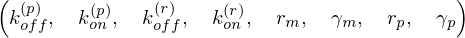

In [9]:
# Define rate constant variables
kp_off, kp_on = sympy.symbols('{k_{off}^{(p)}} {k_{on}^{(p)}}')
kr_off, kr_on = sympy.symbols('{k_{off}^{(r)}} {k_{on}^{(r)}}')

# Define degradation rate and production rate
rm, gm = sympy.symbols('r_m gamma_m')
rp, gp = sympy.symbols('r_p gamma_p')

kp_off, kp_on, kr_off, kr_on, rm, gm, rp, gp

Now let's define a function that given a list of states and a moment of the form $\bb{m^x p^y}$ (as the keys from the dictionary that contains the equation coefficients) it generates an array with the individual moments. For example if the function receives $\bb{m^2 p}$ with three states $\{E, P, R \}$ it returns sympy variables of the form
$$
\ee{m^2 p}_E, \ee{m^2 p}_P, \ee{m^2 p}_R
$$

In [10]:
# Define non-bold variables for m and p
mm, pp = sympy.symbols('m p')
mm, pp

In [11]:
def moment_dict(moments, states=['E', 'P', 'R']):
    '''
    Function that generates automatically sympy variables for a given moment
    one for each of the specified states.
    
    Parameters
    ----------
    moments : list.
        List of sympy variables of the form m**x * p**y for which to 
        generate the moment variables.
    states : array-like.
        List containing strings that define each of the states for which
        to define the moment variables.
        
    Returns
    -------
    moments_dict : dictionary.
        dictionary containing all new defined variables associated with each
        moment.
    '''
    # Initialize dictionary to save the variables
    moments_dict = dict()
    
    # Loop through each of the moments adding the variables to the dictionary
    for mom in moments:
        # Process non-zero moments
        if mom != 1:
            # Find the degree of the moment for each of the variables
            if mom.has(m):
                m_degree = sympy.Poly(mom).degree(m)
            else:
                m_degree = 0
            if mom.has(p):
                p_degree = sympy.Poly(mom).degree(p)
            else:
                p_degree = 0

            # Initialize list to save variables
            mom_var = list()

            # Loop through states to generate the variables
            for s in states:
                mom_var.append(sympy.Symbol('{\\langle ' +
                               sympy.latex(mm**m_degree * pp**p_degree) +
                                            '\\rangle}_' + s))
        else:
            # Initialize list to save variables
            mom_var = list()
            
            # Loop through states to generate the variables
            for s in states:
                mom_var.append(sympy.Symbol('{\\langle m^0 p^0' +
                                            '\\rangle}_' + s))
        # Append variables to dictionary
        moments_dict[mom] = mom_var
        
    return moments_dict

Let's generate a dictionary for the variables in the protein second moment dictionary we saved earlier.

In [12]:
# Extract keys from the p2_dict
p2_keys = [key for key, val in p2_dict.items()]

# Generate dictionary with variables for each variable in dictionary
p2_var_dict = moment_dict(p2_keys)

p2_var_dict

#### Testing system with unregulated promoter.

We now have everything in place to try to solve for moments. As an example case let's try to find the first mRNA moment for the **unregualted promoter**. For this we need first to define the matrices for this case.

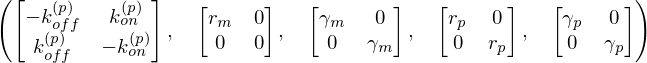

In [13]:
# Define the rate constant matrix
Km_unreg = sympy.Matrix([[-kp_off, kp_on], 
                           [kp_off, -kp_on]])
# Define the mRNA production matrix
Rm_unreg = sympy.Matrix([[rm, 0], 
                         [0, 0]])
# Define the mRNA degradation matrix
Gm_unreg = sympy.Matrix([[gm, 0],
                         [0, gm]])

# Define the protein production matrix
Rp_unreg = sympy.Matrix([[rp, 0], 
                         [0, rp]])
# Define the protein degradation matrix
Gp_unreg = sympy.Matrix([[gp, 0],
                         [0, gp]])


Km_unreg, Rm_unreg, Gm_unreg, Rp_unreg, Gp_unreg

Now let's find the general equation for this first moment.

In [14]:
# Find the equation for the first moment.
m1_eq = master_moment.subs([[x, 1], [y, 0]]).factor([m, p])

sympy.Eq(0, m1_eq)

Next we extract the coefficients of this equation.

In [15]:
# Extract coefficients from equation
m1_coeff_dict = coeff_dictionary(m1_eq)

m1_coeff_dict

Now we define the moment variables for this system

In [16]:
# Extract keys from dictionary
m1_keys = [key for key, value in m1_coeff_dict.items()]

# Generate variables for each of the moments
m1_var_dict = moment_dict(m1_keys, states=['E', 'P'])

m1_var_dict

We now define the augmented matrix to solve the linear system.

**NOTE:** on `sympy` getting to substitute a term like $(\Km - \Gm)$ with the corresponding matrices and then actually doing the subtraction is very convoluted. If you want to reproduce this make sure you follow the instructions.

First to simplify things let's generate a dictionary that instead of having the coefficients as `m1_coeff_dict` it has the substituted matrices.

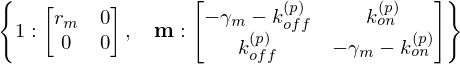

In [17]:
# Initialize dictionary to save the matrices
m1_mat_dict = dict()


tmp_list = list()
# Loop through each of the coefficients and compute the operation
# NOTE: It is quite tricky to get it to work on sympy
for key, value in m1_coeff_dict.items():
    # Extract arguments for the item
    args = value.args
    # Find if any of the arguments is a number
    
    # Check each of the possible cases
    # 1. args is empty and value is zero : 
    # That is a term of the form {key : 0}
    # Generate a matrix of zeros
    if (len(args) == 0) & (value == 0):
        m1_mat_dict[key] = sympy.zeros(*Km_unreg.shape)
   
    # 2. args is empty and value is not zero :
    # That is the case where the term is a single matrix
    # Substitute that value with the actual definition of the matrix
    elif (len(args) == 0) & (value != 0):
        m1_mat_dict[key] = value.subs([[Km, Km_unreg],
                                       [Rm, Rm_unreg],
                                       [Gm, Gm_unreg],
                                       [Rp, Rp_unreg],
                                       [Gp, Gp_unreg]])

    # 3. args is not empty but one of the terms is an integer :
    # That is the case where we have Number * Matrix.
    # substitute the matrix and multiply it by the number
    elif (len(args) != 0) & (any([x.is_Number for x in args])):
        # Substitute value
        term_list = [x.subs([[Km, Km_unreg],
                             [Rm, Rm_unreg],
                             [Gm, Gm_unreg],
                             [Rp, Rp_unreg],
                             [Gp, Gp_unreg]]) for x in value.args]
        # Multiply matrix by constant and register case
        m1_mat_dict[key] = np.prod(term_list)
    
    # 4. args is not empty and non of the elements is an integer :
    # Substitute matrices and reduce to single matrix.
    else:
        term_list = [x.subs([[Km, Km_unreg],
                             [Rm, Rm_unreg],
                             [Gm, Gm_unreg],
                             [Rp, Rp_unreg],
                             [Gp, Gp_unreg]]) for x in value.args]

        # Perform a second round of checking. Elements that have for example
        # Number * Matrix are not explicitly multiplied. For this we will use
        # np.prod by splitting the terms again into its arguments and
        # multiplying the the arguments
        for i, term in enumerate(term_list):
            if len(term.args) == 2:
                term_list[i] = np.prod(term.args)

        # Add the matrices. In order to do so:
        # the sum function has an optional "start" argument so you can 
        # initialize it with a "zero object" of the kind you are adding. 
        # In this case, with a zero matrix.
        m1_mat_dict[key] = sum(term_list, sympy.zeros(*Km_unreg.shape))

m1_mat_dict

After that convoluted substitution we have everything that we need for building the augmented matrix.

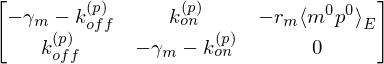

In [18]:
moment = m
# Find the keys for the elements that are not the element we are computing
m1_right_keys = [key for key, value in m1_mat_dict.items() if key != moment]

# Initialize matrix that will be added to the right hand side
m1_right_hand = sympy.zeros(2, 1)

# Loop through each of the keys and add to this matrix
for key in m1_right_keys:
    m1_right_hand = m1_right_hand + m1_mat_dict[key] *\
                                    sympy.Matrix(m1_var_dict[key])

# add columns on the right hand side of minus the rest of the elements
m1_aug_mat = m1_mat_dict[moment].col_insert(2, - m1_right_hand)
m1_aug_mat

Solve the linear system to obtain the first moment!

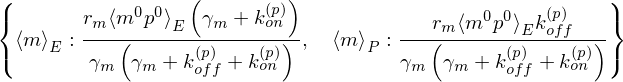

In [19]:
# Solve linear system for the three moments
m1_unreg_dict = sympy.solve_linear_system(m1_aug_mat, *m1_var_dict[m])
m1_unreg_dict

Now we compute the sum of each of the elements to get the global first moment $\ee{m}$

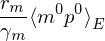

In [20]:
m1_unreg = sum(m1_unreg_dict.values()).simplify()
m1_unreg

This is exactly the expected solution! It seems that the method is working.

#### Defining a function for this computation.

Given the long list of steps in this process let's define a function that given a moment $\ee{m^x p^y}$ goes through the entire process of solving the linear system.

First we define a function that given a dictionary containing all the coefficients for each of the moments it performs the appropriate substitutions and returns a dictionary containing the evaluated matrices. This is a little tricky to do with `sympy` and the function has to go through each of the possible scenarios of the form:
1. {moment : $0$}
2. {moment : $\bb{A}$} with $\bb{A}$ one of the matrices from the CME
3. {moment : $N \bb{A}$} with $N \in \mathbb{Z}$
4. {moment : $(N \bb{A} \pm N' \bb{B})$ with $\bb{A}$ and $\bb{B}$ being matrices and $N, N' \in \mathbb{Z}$

In [21]:
def coeff_subs(coeff_dict, Km_mat, Rm_mat, Gm_mat, Rp_mat, Gp_mat):
    '''

    Parameters
    ----------
    coeff_dict : dictionary.
        Dictionary containing all the coefficients associated with each of the
        moments in the moment equation.
    Km_mat, Rm_mat, Gm_mat, Rp_mat, Gp_mat: 2D sympy matrices.
        Sympy matrices that define the master equation.
        Km_mat : transition between states
        Rm_mat : mRNA produciton
        Gm_mat : mRNA degradation
        Rp_mat : protein production
        Gp_mat : protein degradation

    Returns
    -------
    mom_mat_dict : dictionary.
        Dictionary containing each of the substitutted coefficients into matrices
    '''
    # Initialize dictionary to save the matrices
    mom_mat_dict = dict()

    # Loop through each of the coefficients and compute the operation
    # NOTE: It is quite tricky to get it to work on sympy
    for key, value in coeff_dict.items():
        # Extract arguments for the item
        args = value.args

        # Check each of the possible cases

        # 1. args is empty and value is zero :
        # That is a term of the form {key : 0}
        # Generate a matrix of zeros
        if (len(args) == 0) & (value == 0):
            mom_mat_dict[key] = sympy.zeros(*Km_mat.shape)

        # 2. args is empty and value is not zero :
        # That is the case where the term is a single matrix
        # Substitute that value with the actual definition of the matrix
        elif (len(args) == 0) & (value != 0):
            mom_mat_dict[key] = value.subs([[Km, Km_mat],
                                            [Rm, Rm_mat],
                                            [Gm, Gm_mat],
                                            [Rp, Rp_mat],
                                            [Gp, Gp_mat]])

        # 3. args is not empty but one of the terms is an integer :
        # That is the case where we have Number * Matrix.
        # substitute the matrix and multiply it by the number
        elif (len(args) != 0) & (any([x.is_Number for x in args])):
            # Substitute value
            term_list = [x.subs([[Km, Km_mat],
                                 [Rm, Rm_mat],
                                 [Gm, Gm_mat],
                                 [Rp, Rp_mat],
                                 [Gp, Gp_mat]]) for x in value.args]
            # Multiply matrix by constant and register case
            mom_mat_dict[key] = np.prod(term_list)

        # 4. args is not empty and non of the elements is an integer :
        # Substitute matrices and reduce to single matrix.
        else:
            term_list = [x.subs([[Km, Km_mat],
                                 [Rm, Rm_mat],
                                 [Gm, Gm_mat],
                                 [Rp, Rp_mat],
                                 [Gp, Gp_mat]]) for x in value.args]

            # Perform a second round of checking. Elements that have for example
            # Number * Matrix are not explicitly multiplied. For this we will use
            # np.prod by splitting the terms again into its arguments and
            # multiplying the the arguments
            for i, term in enumerate(term_list):
                if len(term.args) == 2:
                    term_list[i] = np.prod(term.args)

            # Add the matrices. In order to do so:
            # the sum function has an optional "start" argument so you can
            # initialize it with a "zero object" of the kind you are adding.
            # In this case, with a zero matrix.
            mom_mat_dict[key] = sum(term_list, sympy.zeros(*Km_mat.shape))
            
    return mom_mat_dict

Let's test the function generating the dictionary associated with the protein second moment.

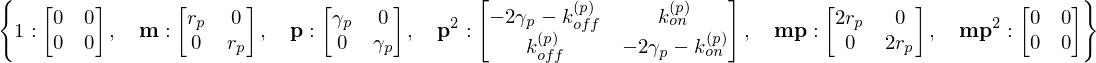

In [22]:
mom_coeff_dict = coeff_dictionary(master_moment.\
                                  subs([[x, 0], [y, 2]]).factor([m, p]))
coeff_subs(mom_coeff_dict, Km_unreg, Rm_unreg, Gm_unreg, Rp_unreg, Gp_unreg)

Now let's define a function that given a general moment equation, a set of exponents for the desired moments and a lists of matrices and states it solves the system for the desired moment.

In [70]:
def solve_moment(moment_eq, m_expo, p_expo,
                 Km_mat, Rm_mat, Gm_mat, Rp_mat, Gp_mat,
                 states=['E', 'P', 'R']):
    '''
    Function that given a general moment equation and some exponents it solves
    the linear system for m**m_expo * p**p_expo at steady state.
    
    Parameters
    ----------
    moment_eq : sympy expression.
        Sympy equation for the general moment.
    m_expo, p_expo : int.
        Exponent of the moments that should be computed. These moments indicate
        the moment of the form <m**m_expo * p**p_expo> that should be computed.
    Km_mat, Rm_mat, Gm_mat, Rp_mat, Gp_mat: 2D sympy matrices.
        Sympy matrices that define the master equation.
        Km_mat : transition between states
        Rm_mat : mRNA produciton
        Gm_mat : mRNA degradation
        Rp_mat : protein production
        Gp_mat : protein degradation
    states : array-like.
        List of the name of the states that are included in the system.
        
    Returns
    -------
    mom_sol_dict : dictionary.
        Dictionary containing the solution to the linear system for the desired
        moment.
    '''
    # Define sympy variable for moment
    moment = m**m_expo * p**p_expo
    
    # Find the equation for the moment.
    mom_eq = moment_eq.subs([[x, m_expo], [y, p_expo]]).factor([m, p])
    
    # Extract coefficients from equation and save them as a dictionary
    # in which each key is the moment and each value is the coefficient
    # associated with that moment
    mom_coeff_dict = coeff_dictionary(mom_eq)
    
    # Extract keys from dictionary
    mom_keys = [key for key, value in mom_coeff_dict.items()]

    # Generate variables for each of the moments and save them
    # as a dictionary in which each key is the moment and each value
    # is a list of the variables associated with the moment
    mom_var_dict = moment_dict(mom_keys, states=states)
    
    # If asked for the zeroth moment the extendedm matrix is different
    if m_expo + p_expo == 0:
        # Build extended matrix adding extra row for normalization constraint
        # Add the extra row for the normalization constraint
        mom_aug_mat = Km_mat.row_insert(0,
                      sympy.ones(1, Km_mat.shape[0]))

        # Define right-side array
        b = sympy.zeros(mom_aug_mat.shape[0], 1)
        b[0] = 1

        # Define augmented matrix
        mom_aug_mat = mom_aug_mat.col_insert(mom_aug_mat.shape[1], b)
    
        # Solve linear system for the moments
        return sympy.solve_linear_system(mom_aug_mat, *mom_var_dict[moment])
        
    # Obtain dictionary with subsituted matrices for each of the coefficients
    # in the moment equation
    mom_mat_dict = coeff_subs(mom_coeff_dict, Km_mat, Rm_mat, Gm_mat, 
                              Rp_mat, Gp_mat)

    # Find the keys for the elements that are not the element we are computing
    mom_right_keys = [key for key, value in mom_mat_dict.items() if key != moment]

    # Initialize matrix that will be added to the right hand side
    mom_right_hand = sympy.zeros(Km_mat.shape[0], 1)

    # Loop through each of the keys and add to this matrix
    for key in mom_right_keys:
        mom_right_hand = mom_right_hand + mom_mat_dict[key] *\
                                        sympy.Matrix(mom_var_dict[key])

    # add columns on the right hand side of minus the rest of the elements
    mom_aug_mat = mom_mat_dict[moment].col_insert(Km_mat.shape[0], 
                                                  - mom_right_hand)
    
    # Solve linear system for the three moments
    mom_sol_dict = sympy.solve_linear_system(mom_aug_mat, 
                                               *mom_var_dict[moment])
    
    return mom_sol_dict

Let's obtain the first protein moment $\ee{p}$ to check that the function works.

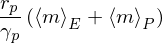

In [71]:
p1_unreg_dict = solve_moment(master_moment, 0, 1,
                           Km_unreg, Rm_unreg, Gm_unreg, Rp_unreg, Gp_unreg,
                           ['E', 'P'])

sum(p1_unreg_dict.values()).simplify()

This is the right answer!

## Systematically obtain moments as function of rates

Now that we have this function working we can compute up to a desired moment $\ee{m^x p^y}$ by systematically solving the system for all moments $\ee{m^{x'} p^{y'}}$ such that $x' + y' \leq x + y$ and then substituting each solution on the other.

Let's define a function that performs this systematic calculation. For a given mRNA and protein power $x$ and $y$ it finds all possible pairs of exponents that add up to a number less than the sum.

In [25]:
# Define exponents
m_exp, p_exp = 0, 4

# Find possible pairs of exponents
expo_pairs = list(itertools.permutations(range(max([m_exp, p_exp]) + 1), 2))

# Add the (num, num) pair that are not being included
expo_pairs = expo_pairs + [tuple([s, s]) for s in range(max([m_exp, p_exp]))]

# Remove the ones that does not satisfy x' + y' <= x + y
expo_pairs = [x for x in expo_pairs if sum(x) <= m_exp + p_exp]

# Initialize dictionary that will save each of the solutions dictionaries
# That's right, this will be a dictionary with dictionaries as values for each key
mom_sol_dict = {m**x * p**y : solve_moment(master_moment, x, y,
                              Km_unreg, Rm_unreg, Gm_unreg, Rp_unreg, Gp_unreg,
                              ['E', 'P']) 
               for (x, y) in expo_pairs}

In order to do the substitutions in the proper order we will define a function that sorts the moments as follows:
- Firt all of the mRNA moments $(x, 0)$
- Then each protein moment $(0, y)$ preceded by the cross correlations $(x', y')$ such that $x' + y' = y$

This will allow us to do the systematic substitutions in the correct order to find all the moments purely as as function of the rates in the master equation.

In [26]:
def sort_moments(expo_pairs):
    '''
    Sorts the moments in the right order for the substitutions to be done in the
    proper order
    
    Parameter
    ---------
    expo_pairs : list.
        list of exponents of the moments to be sorted
    
    Returns
    -------
    expo_sorted : list.
        List of exponentes sorted in the right way
    '''
    # Initialize list to append sorted moments
    expo_sorted = list()
    
    # Append mRNA moments
    mRNA_mom = sorted([s for s in expo_pairs if s[1] == 0])
    expo_sorted.append(mRNA_mom)
    
    # Find each protein moment
    protein_mom = sorted([s for s in expo_pairs if (s[0] == 0) & (s[1] != 0)])
    
    # Loop through each protein moment and find the cross correlations
    # associated with it
    for p in protein_mom:
        cross_corr = sorted([s for s in expo_pairs
                             if (s[0] > 0) & (s[1] > 0) & (sum(s) == p[1])],
                            reverse=True)
        # append it to the list
        expo_sorted.append(cross_corr)
        expo_sorted.append([p])
    
    
    return list(itertools.chain.from_iterable(expo_sorted))

Now we can perform the systematic substitution of the solutions!
It is a tricky convoluted system. Not very pretty, but effective.

In [27]:
# Extract all variables involved in the solutionsk
keys = [key for key in mom_sol_dict.keys()]
mom_vars = [value for key, value  in moment_dict(keys).items()]
mom_vars = list(itertools.chain.from_iterable(mom_vars))

# Initialize array with substituted solutions. For this we only need to
# start with the zeroth moment
mom_sol_subs_dict = mom_sol_dict[1].copy()

# Sort the exponents to perform the substitutions in the right order
expo_sorted = sort_moments(expo_pairs)

# Loop through each of the moments substituting the solution of the previous one
for m_exp, p_exp in expo_sorted[1:]:
    print(m_exp, p_exp)
    # Extract moment to be substituted
    sub_mom = mom_sol_dict[m**m_exp * p**p_exp].copy()
    
    # Loop through each of the elements of this moment
    for mom_raw, sol_raw in sub_mom.items():
        # Find all variables involved in this solution
        symbols = list(set(list(sol_raw.free_symbols)))
        
        # Keep only the moment variables to be substituted
        var_subs = [s for s in symbols if s in mom_vars]
        
        # Initialize dictionary to save all substituted variables
        sub_dict = dict()
        # Loop through these variables substitutting them
        for var in var_subs:
            sub_dict[var] = mom_sol_subs_dict[var]
            
        # Substitute all variables
        sub_mom[mom_raw] = sub_mom[mom_raw].subs(sub_dict)
    
        # Add substituted solution to dictionary
        mom_sol_subs_dict[mom_raw] = sub_mom[mom_raw]

1 0
2 0
3 0
4 0
0 1
1 1
0 2
2 1
1 2
0 3
3 1
2 2
1 3
0 4


### Generate `lambdify` functions.

Having computed the solutions purely as function of the rates we now can generate the `lambdify` functions that will allow us to evaluate these moments numerically.

In order to make this effective we will generate a dictionary where the `key` will be a pair of exponents $(x, y)$ and the `value` will be will be the `lambidfy` function for the global moment.

First let's collect the global moments by adding the individual promoter state moments.

In [28]:
# Extract the moments
moments = [key for key in mom_sol_dict.keys()]

# Generate the dictionary with all the variables
mom_var_dict = moment_dict(moments, states=['E', 'P'])

# Initialize dictionary to save global moments
mom_global = {}

# Loop through each of the moments, extract the solution for each of the
# moments and add them to obtain the global moment
for key, value in mom_var_dict.items():
    # Extract the solutions for each individual moment and add them
    mom_global[key] = sum([mom_sol_subs_dict[s] for s in value])

Let's confirm that all the substitutions were done correctly by checking the `free_symbols` for each of the global moments.

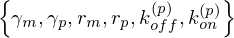

In [29]:
# Initialize list to save variables on each moment
mom_global_var = list()

# Loop trhough each moment and extract the free symbols
for key, value in mom_global.items():
    mom_global_var.append(list(value.free_symbols))

# Find the unique variables
unique_sym = set([item for sublist in mom_global_var for item in sublist])
unique_sym

Not a single moment variable $\ee{m^x p^y}$. Therefore the systematic substitution worked as expected.

Having the global moments now let's generate the `lambdify` functions and store them in a dictionary where the keys will not be the `sympy` variables for the moment since this dictionary will be saved and imported in other notebooks. Instead the key will be a tuple of the form $(x, y)$.

In [35]:
# Define array containing variables
var = [kp_on, kp_off, rm, gm, rp, gp]

# Initialize dictionary to save lambdify functions
mom_global_lambdify = {}

# Loop through every global moment
for key, value in mom_global.items():
    # Find the exponents of the moment
    if key.has(m):
        m_degree = sympy.Poly(key).degree(m)
    else:
        m_degree = 0
    if key.has(p):
        p_degree = sympy.Poly(key).degree(p)
    else:
        p_degree = 0
    print((m_degree, p_degree))
    
    # Generate and save into the dictionary the lambdify function.
    mom_global_lambdify[(m_degree, p_degree)] = sympy.lambdify(var, value, 
                                                               modules='numexpr')

(0, 1)
(0, 2)
(0, 3)
(0, 4)
(1, 0)
(1, 2)
(1, 3)
(2, 0)
(2, 1)
(3, 0)
(3, 1)
(4, 0)
(0, 0)
(1, 1)
(2, 2)


In [59]:
export = False
if export:
    # Open file to save functions
    with open('./two_state_moments_lambdify.dill', 'wb') as file:
        cloudpickle.dump(mom_global_lambdify, file)

### Repeat calculation for three-state promoter.

Having obtained up to the fourth protein moment for the unregulated case let's now proceed to the regulated one where we will repeat the same analysis defining the corresponding matrices.

Let's first define the corresponding matrices.

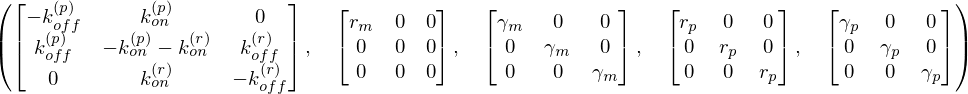

In [60]:
# Define the rate constant matrix
Km_reg = sympy.Matrix([[-kp_off, kp_on, 0], 
                         [kp_off, -(kp_on + kr_on), kr_off],
                         [0, kr_on, -kr_off]])
# Define the production matrix
Rm_reg = sympy.Matrix([[rm, 0, 0],
                       [0, 0, 0],
                       [0, 0, 0]])
# Define the degradation matrix
Gm_reg = sympy.Matrix([[gm, 0, 0],
                       [0, gm, 0],
                       [0, 0, gm]])

# Define the production matrix
Rp_reg = sympy.Matrix([[rp, 0, 0],
                       [0, rp, 0],
                       [0, 0, rp]])

# Define the production matrix
Gp_reg = sympy.Matrix([[gp, 0, 0],
                       [0, gp, 0],
                       [0, 0, gp]])


Km_reg, Rm_reg, Gm_reg, Rp_reg, Gp_reg

Now we compute the moments for this three-state case adding the `R` state.

In [72]:
# Define exponents
m_exp, p_exp = 0, 4

# Find possible pairs of exponents
expo_pairs = list(itertools.permutations(range(max([m_exp, p_exp]) + 1), 2))

# Add the (num, num) pair that are not being included
expo_pairs = expo_pairs + [tuple([s, s]) for s in range(max([m_exp, p_exp]))]

# Remove the ones that does not satisfy x' + y' <= x + y
expo_pairs = [x for x in expo_pairs if sum(x) <= m_exp + p_exp]

# Initialize dictionary that will save each of the solutions dictionaries
# That's right, this will be a dictionary with dictionaries as values for each key
mom_sol_dict = {m**x * p**y : solve_moment(master_moment, x, y,
                              Km_reg, Rm_reg, Gm_reg, Rp_reg, Gp_reg,
                              ['E', 'P', 'R']) 
               for (x, y) in expo_pairs}

Now the systematic substitutions to generate the moments as function of the rates.

In [ ]:
# Extract all variables involved in the solutionsk
keys = [key for key in mom_sol_dict.keys()]
mom_vars = [value for key, value  in moment_dict(keys).items()]
mom_vars = list(itertools.chain.from_iterable(mom_vars))

# Initialize array with substituted solutions. For this we only need to
# start with the zeroth moment
mom_sol_subs_dict = mom_sol_dict[1].copy()

# Sort the exponents to perform the substitutions in the right order
expo_sorted = sort_moments(expo_pairs)

# Loop through each of the moments substituting the solution of the previous one
for m_exp, p_exp in expo_sorted[1:]:
    print(m_exp, p_exp)
    # Extract moment to be substituted
    sub_mom = mom_sol_dict[m**m_exp * p**p_exp].copy()
    
    # Loop through each of the elements of this moment
    for mom_raw, sol_raw in sub_mom.items():
        # Find all variables involved in this solution
        symbols = list(set(list(sol_raw.free_symbols)))
        
        # Keep only the moment variables to be substituted
        var_subs = [s for s in symbols if s in mom_vars]
        
        # Initialize dictionary to save all substituted variables
        sub_dict = dict()
        # Loop through these variables substitutting them
        for var in var_subs:
            sub_dict[var] = mom_sol_subs_dict[var]
            
        # Substitute all variables
        sub_mom[mom_raw] = sub_mom[mom_raw].subs(sub_dict)
    
        # Add substituted solution to dictionary
        mom_sol_subs_dict[mom_raw] = sub_mom[mom_raw]

1 0
2 0
3 0
4 0
0 1
1 1
0 2
2 1
1 2
0 3
3 1
2 2


Again we check that all the moment variables were correctly substituted by listing the unique variables found in the moments.

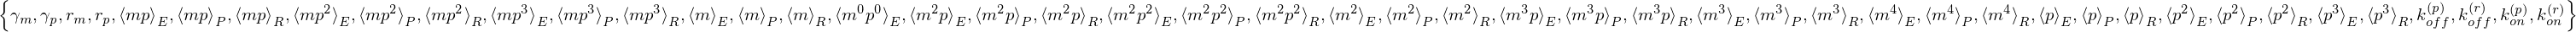

In [83]:
# Initialize list to save variables on each moment
mom_global_var = list()

# Loop trhough each moment and extract the free symbols
for key, value in mom_sol_subs_dict.items():
    mom_global_var.append(list(value.free_symbols))

# Find the unique variables
unique_sym = set([item for sublist in mom_global_var for item in sublist])
unique_sym

And finally generate the `lambdify` expressions for each of these moments.

In [79]:
# Define array containing variables
var = [kp_on, kp_off, rm, gm, rp, gp]

# Initialize dictionary to save lambdify functions
mom_global_lambdify = {}

# Loop through every global moment
for key, value in mom_global.items():
    # Find the exponents of the moment
    if key.has(m):
        m_degree = sympy.Poly(key).degree(m)
    else:
        m_degree = 0
    if key.has(p):
        p_degree = sympy.Poly(key).degree(p)
    else:
        p_degree = 0
    print((m_degree, p_degree))
    
    # Generate and save into the dictionary the lambdify function.
    mom_global_lambdify[(m_degree, p_degree)] = sympy.lambdify(var, value, 
                                                               modules='numexpr')

(0, 1)
(0, 2)
(0, 3)
(0, 4)
(1, 0)
(1, 2)
(1, 3)
(2, 0)
(2, 1)
(3, 0)
(3, 1)
(4, 0)
(0, 0)
(1, 1)
(2, 2)


In [80]:
export = False
if export:
    # Open file to save functions
    with open('./three_state_moments_lambdify.dill', 'wb') as file:
        cloudpickle.dump(mom_global_lambdify, file)